# Lexical Predictability

This code aims to calculate the lexical predictability of disordered text from local to global using GPT2 model and analyze the effect of disorder level and context length on predictability.

## 1. Disordered text
generate 600 samples: disorder level 10%-60%, 100 samples for each level


In [ ]:
import requests
from bs4 import BeautifulSoup
import codecs
import random
from tqdm import tqdm
import csv
import os

### download and preprocess the text sample

In [2]:
## download text file from url

url = "https://www.gutenberg.org/files/1228/1228-h/1228-h.htm"
save_path = "origin_of_species.txt"

# Send a GET request to the URL
response = requests.get(url)

# parse the HTML content
soup = BeautifulSoup(response.content, "html.parser")

# Extract the plain text content
text = soup.get_text()

# save to a txt file
with open(save_path, "w", encoding="utf-8") as file:
    file.write(text)

print("downloaded successfully!")

downloaded successfully!


In [4]:
## clean the text

bookfile=save_path
with codecs.open(bookfile, encoding="utf8") as f:
    book=f.read()
end_word = "evolved"
end_index = book.find(end_word)+len(end_word)
book=book[: end_index].replace("\r", "")
book = re.sub(r'(?<!\n)\n(?!\n)', ' ', book)
book = re.sub(r'\n+', '\n', book)
chapters_num = 15
pattern = re.compile(r'^(INTRODUCTION|CHAPTER)', re.MULTILINE)
chapters= re.split(pattern, book)[-chapters_num*2+1::2]
chapters

In [65]:
# randomly select one chapter
chapt_id = random.randint(0,len(chapters)-1)
chapter = chapters[chapt_id]
chapter_words=chapter.split()


In [ ]:
# Generate the shuffled samples

num=100
dataset = []
disorder_levels = [round(i/10, 1) for i in range(1,7)]

for i in range(num):

    # Random Extract the sample consisting of 100 words
    end_id = random.randint(num, len(chapter_words))
    sample_words = chapter_words[end_id-num:end_id]
    sample_original = ' '.join(sample_words)
    sample_word_ids = [s for s in range(len(sample_words))]
    
    
    for level in disorder_levels:

        # Sample disorder_level proportion of indices to shuffle
        proportion = int(level * len(sample_word_ids))

        # Get sampled indices and sort them
        words_ids_sampled = random.sample(population=sample_word_ids, k=proportion)
        words_ids_sampled_sorted = sorted(words_ids_sampled)

        # Create copy of initial words to be modified
        words_sample_shuffled = sample_words[:]

        # Insert shuffled words at positions of unshuffled sampled indices
        for w_sampled_shuffled, w_sampled_sorted in zip (words_ids_sampled, words_ids_sampled_sorted):
            words_sample_shuffled[w_sampled_sorted] = sample_words[w_sampled_shuffled]
        
        # Join words with new order into a word sequence
        sample_shuffled = ' '.join(words_sample_shuffled)

        # add the genrated shuffled sample into the dataset
        dataset.append({
                "disorder_level": level,
                "sample_id": i,
                "sample_original": sample_original,
                "text_shuffled": sample_shuffled
                })


In [104]:
# Save the generated samples

with open(f"Chapter{chapt_id}_100samples.csv", 'w', encoding='utf-8', newline='') as data_file:
    writer = csv.DictWriter(data_file, fieldnames=dataset[0].keys())
    writer.writeheader()
    writer.writerows(dataset)

## 2. Word-by-word predictability

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm
import pandas as pd
import os


In [ ]:
# Load to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

# Load the GPT-2 model and tokenizer
model_name = 'gpt2'  # or 'gpt2-medium', 'gpt2-large', etc.
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()

In [7]:
# read data
file='Chapter4_100samples.csv'
data = pd.read_csv(file)

In [ ]:
def word_by_word_predictability(sample):
    lexical_preds=[]
    
    encoded_sample=tokenizer.encode(sample['sample_shuffled'], return_tensors='pt').to(device)
    encoded_sample_lst = encoded_sample.tolist()[0]
    
    for word_position, word in enumerate(encoded_sample_lst):
        if word_position >= 64:
   
            for context_length in [1,2,4,8,16,32, 64]: #set the context length

                context = encoded_sample[:, word_position - context_length:word_position]

                # Generate predictions for the next word
                with torch.no_grad():
                    outputs = model(context)

                # Extract the predicted logits for the next word
                logits = outputs.logits[0, -1, :]

                # Compute the probabilities using softmax
                probabilities = torch.softmax(logits, dim=0)

                # Compute the probabilities using softmax
                preds = torch.softmax(outputs.logits, dim=-1)
                next_word_prob = preds[:, -1, word].item()

                lexical_preds.append({
                    "disorder_level": sample['disorder_level'],
                    "text": sample['sample_shuffled'],
                    "sample_id": sample['sample_id'],
                    "word": tokenizer.decode([word]),
                    "word_pos": word_position,
                    "context_length": context_length,
                    "context": tokenizer.decode(context[0]),
                    "predictability": next_word_prob
                    })

    
    return lexical_preds
    

In [ ]:
# Compute predictability for all samples

lexical=[]
for level in data.disorder_level.unique():
    preds = []

    print(f"Disorder level: {level}%")
    data_level = data[data['disorder_level'] == level]

    for sample_id, sample in tqdm(data_level.iterrows(), total=len(data_level), leave=False, position=0):
        # Get word-by-word predictability scores, varying context length for each word, for given sample
        preds_sample = word_by_word_predictability(sample)
        preds.extend(preds_sample)

        # Clear memory before next loop
        del preds_sample

    # Convert data to DataFrame
    preds = pd.DataFrame(preds)
    
    lexical.append(preds)
    # Save preds
    preds_file = f"results_level{level}.csv"
    preds.to_csv(preds_file, index=False)


## 3. Result analysis

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad

In [2]:
# Read data
def read_pred_files(files_path):
    # Name the predictability results files start with

    # Create list to append DataFrames to
    dfs = []

    # Select and read pickle files, convert to DataFrame
    for file in os.listdir(files_path):
        if file.startswith('results_level'):
            dfs.append(pd.read_csv(os.path.join(files_path, file)))

    # Concatenate data together and return
    return pd.concat(dfs, axis=0, ignore_index=True)

In [3]:
files_path = os.getcwd()
df_preds = read_pred_files(files_path)

### visualize overall data

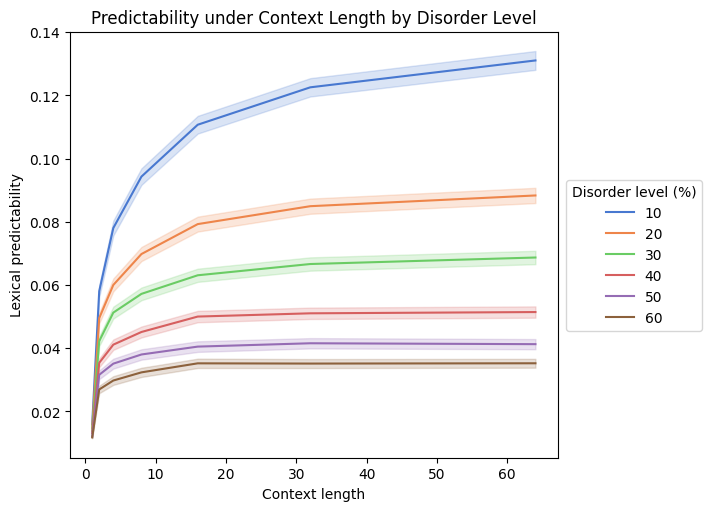

In [4]:
# lineplot

fig, ax = plt.subplots(layout='constrained', figsize=(7,5))
sns.lineplot(ax=ax, data=df_preds, hue='disorder_level', x='context_length', y='predictability', errorbar='se', palette='muted')
plt.xlabel('Context length')
plt.ylabel('Lexical predictability')
plt.title('Predictability under Context Length by Disorder Level')
plt.legend([], [], frameon=False)
fig.legend(loc='outside center right', title='Disorder level (%)')


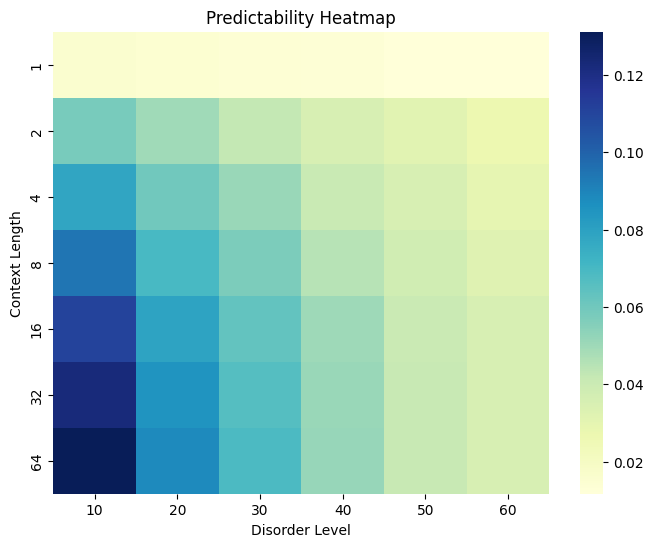

In [5]:
# heatmap
pivot_table = df_preds.pivot_table(values='predictability', index='context_length', columns='disorder_level')
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.xlabel('Disorder Level')
plt.ylabel('Context Length')
plt.title('Predictability Heatmap')
plt.show()

### Model fit

In [6]:
df_agg = df_preds.groupby(['disorder_level', 'context_length'])['predictability'].mean().reset_index()

In [7]:
def fit(df, func):
    params=[]
    for level in df.disorder_level.unique():
        df_level = df[df['disorder_level'] == level]
        x = df_level['context_length'] 
        y = df_level['predictability']  
        params_level, _ = curve_fit(func, x, y)

        y_predicted = func(x, *params_level)
        r_2 = 1 - (np.sum((y - y_predicted) ** 2) / np.sum((y - np.mean(y)) ** 2))

        params.append({
            'disorder_level': level,
            'params': params_level,
            'R_2': r_2
        })
        
    return params

In [8]:
def plot_fit(df, params,  func, save=False):
    fig, axs = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(25,10))
    for i, level in enumerate(df.disorder_level.unique()):
        df_level = df[df['disorder_level'] == level]
        params_level = params[i]['params']

        axs.ravel()[i].plot(df_level['context_length'], func(df_level['context_length'], *params_level), '--', color='red', label='Fitted')
        axs.ravel()[i].plot(df_level['context_length'], df_level['predictability'], 'ro', color='blue', label='Measured')
        axs.ravel()[i].set_title(f"Disorder level: {level}% \n ({', '.join(['='.join(map(str, i)) for i in zip(['a', 'b', 'c', 'd'], [f'{p:0.4f}' for p in params_level])])})")
        # Compute r2
        r2 = params[i]['R_2']
        axs.ravel()[i].text(0.1, 0.9, f"R^2={r2:.2f}", fontsize=20, transform=axs.ravel()[i].transAxes, va='top')

    fig.supxlabel("Context length")
    fig.supylabel("Predictability")

    axs.ravel()[-1].legend()
    plt.tight_layout()


    if save:
        plt.savefig("plot_fit.png", dpi=600, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [9]:
def plot_growth(df, func):
    x=df['disorder_level']
    y=df['growth']
    
    fit_params, _ = curve_fit(func, x, y, maxfev=2000)

    y_predicted = func(x, *fit_params)
    r_2 = 1 - (np.sum((y - y_predicted) ** 2) / np.sum((y - np.mean(y)) ** 2))

    plt.plot(x, func(x, *fit_params), '--',
                            label='Fitted')
    plt.plot(x, y, 'ro', label=f'Measured')

    plt.xlabel("Disorder level (%)")
    plt.ylabel("Integral")
    plt.xticks(ticks=x)
    plt.text(0.7, 0.8, f"R^2={r_2:.2f}", fontsize=20, transform=plt.gca().transAxes, va='top')
    plt.legend()
    plt.title(
        f"{', '.join(['='.join(map(str, i)) for i in zip(['a', 'b', 'c'], [f'{p:0.4f}' for p in fit_params])])}")
    plt.show()

#### linear_model

In [10]:
def linear_func(x, a, b):
    return a*x+b

C:\Users\吴法吴天\AppData\Local\Temp\ipykernel_19868\1507054469.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs.ravel()[i].plot(df_level['context_length'], df_level['predictability'], 'ro', color='blue', label='Measured')


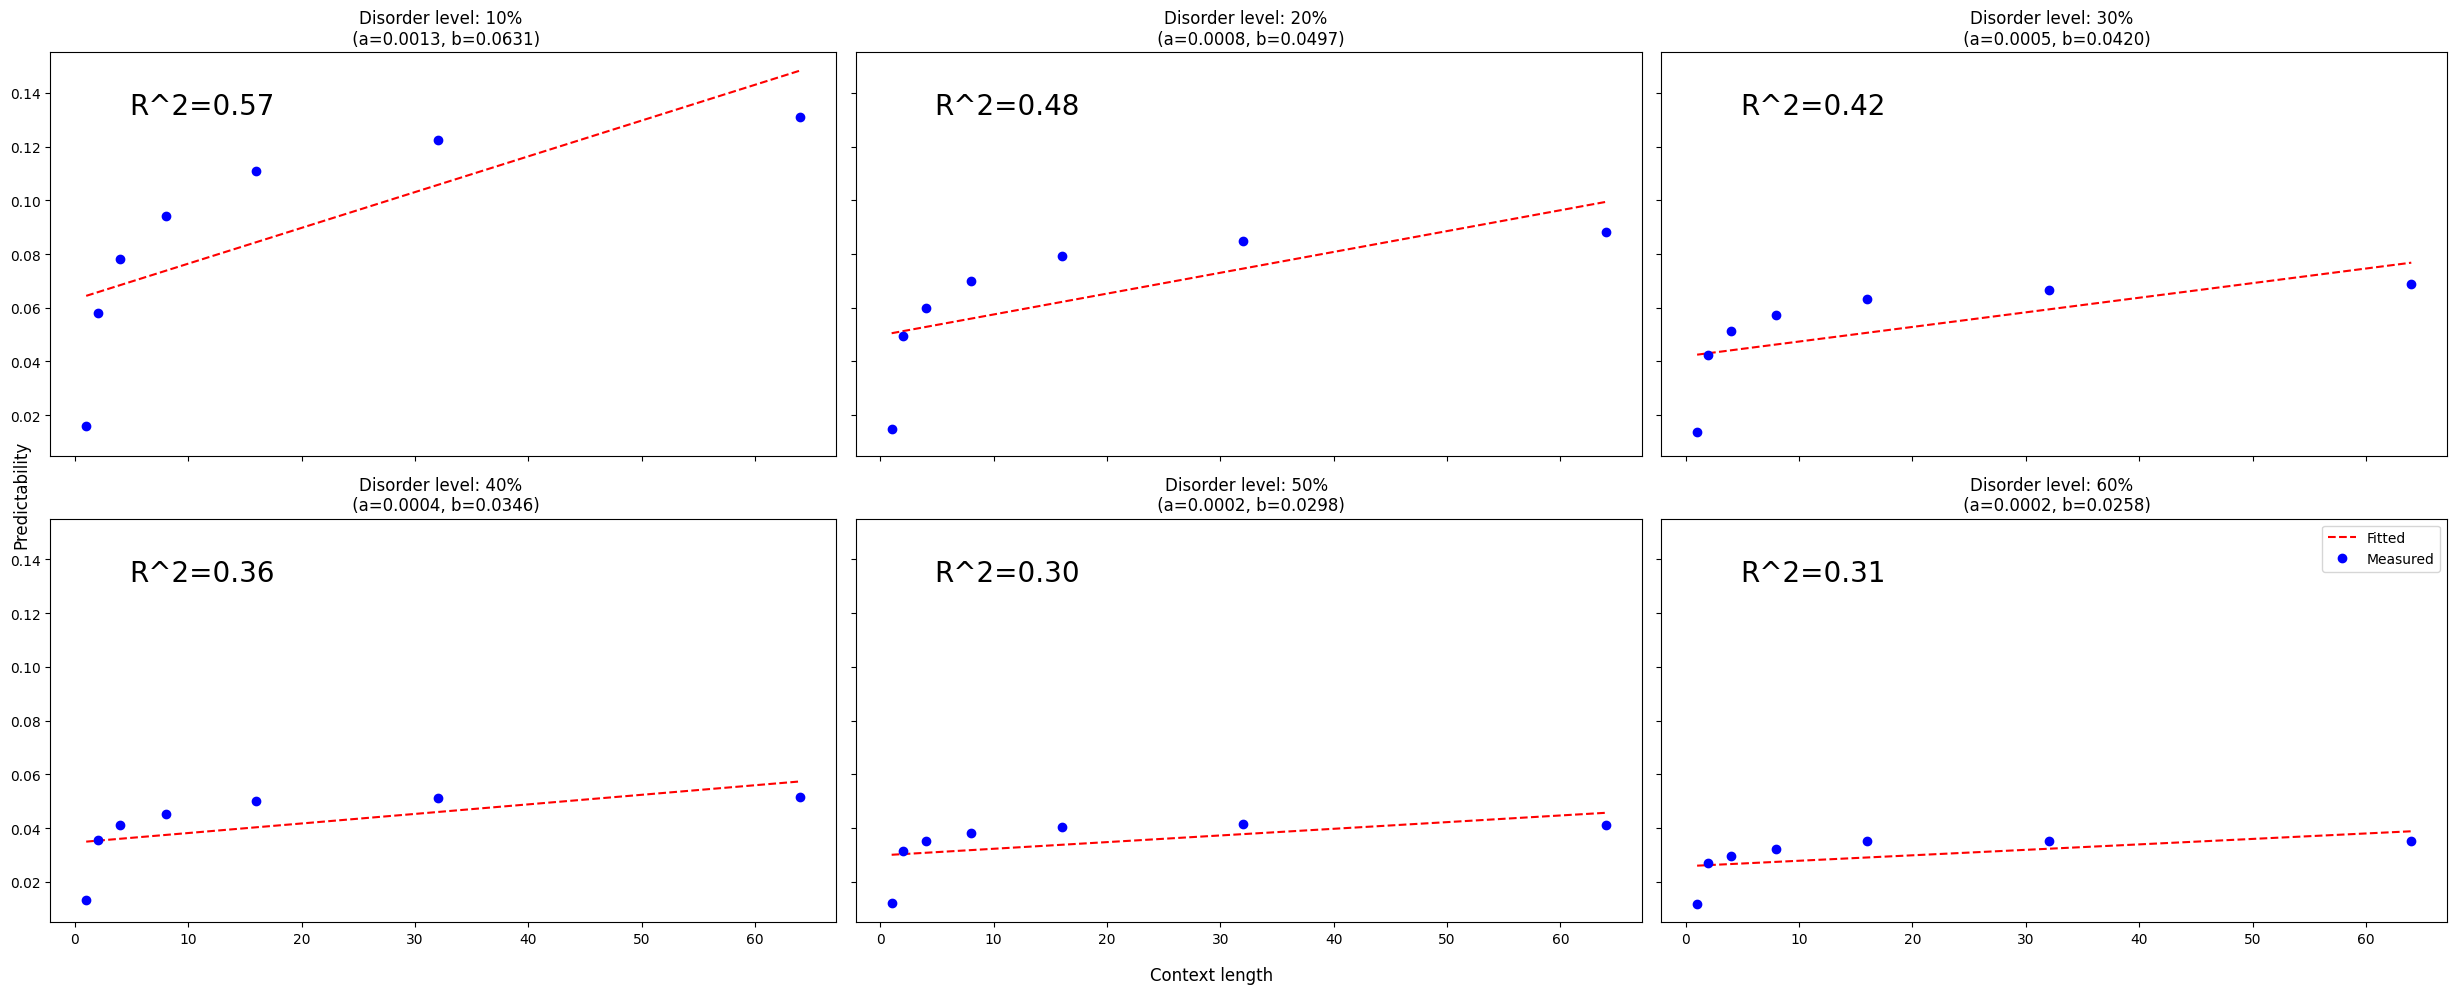

In [11]:
params_lin=fit(df_agg, linear_func)
plot_fit(df_agg, params_lin, linear_func)

#### log model

c:\Users\吴法吴天\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\吴法吴天\AppData\Local\Temp\ipykernel_19868\1507054469.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs.ravel()[i].plot(df_level['context_length'], df_level['predictability'], 'ro', color='blue', label='Measured')


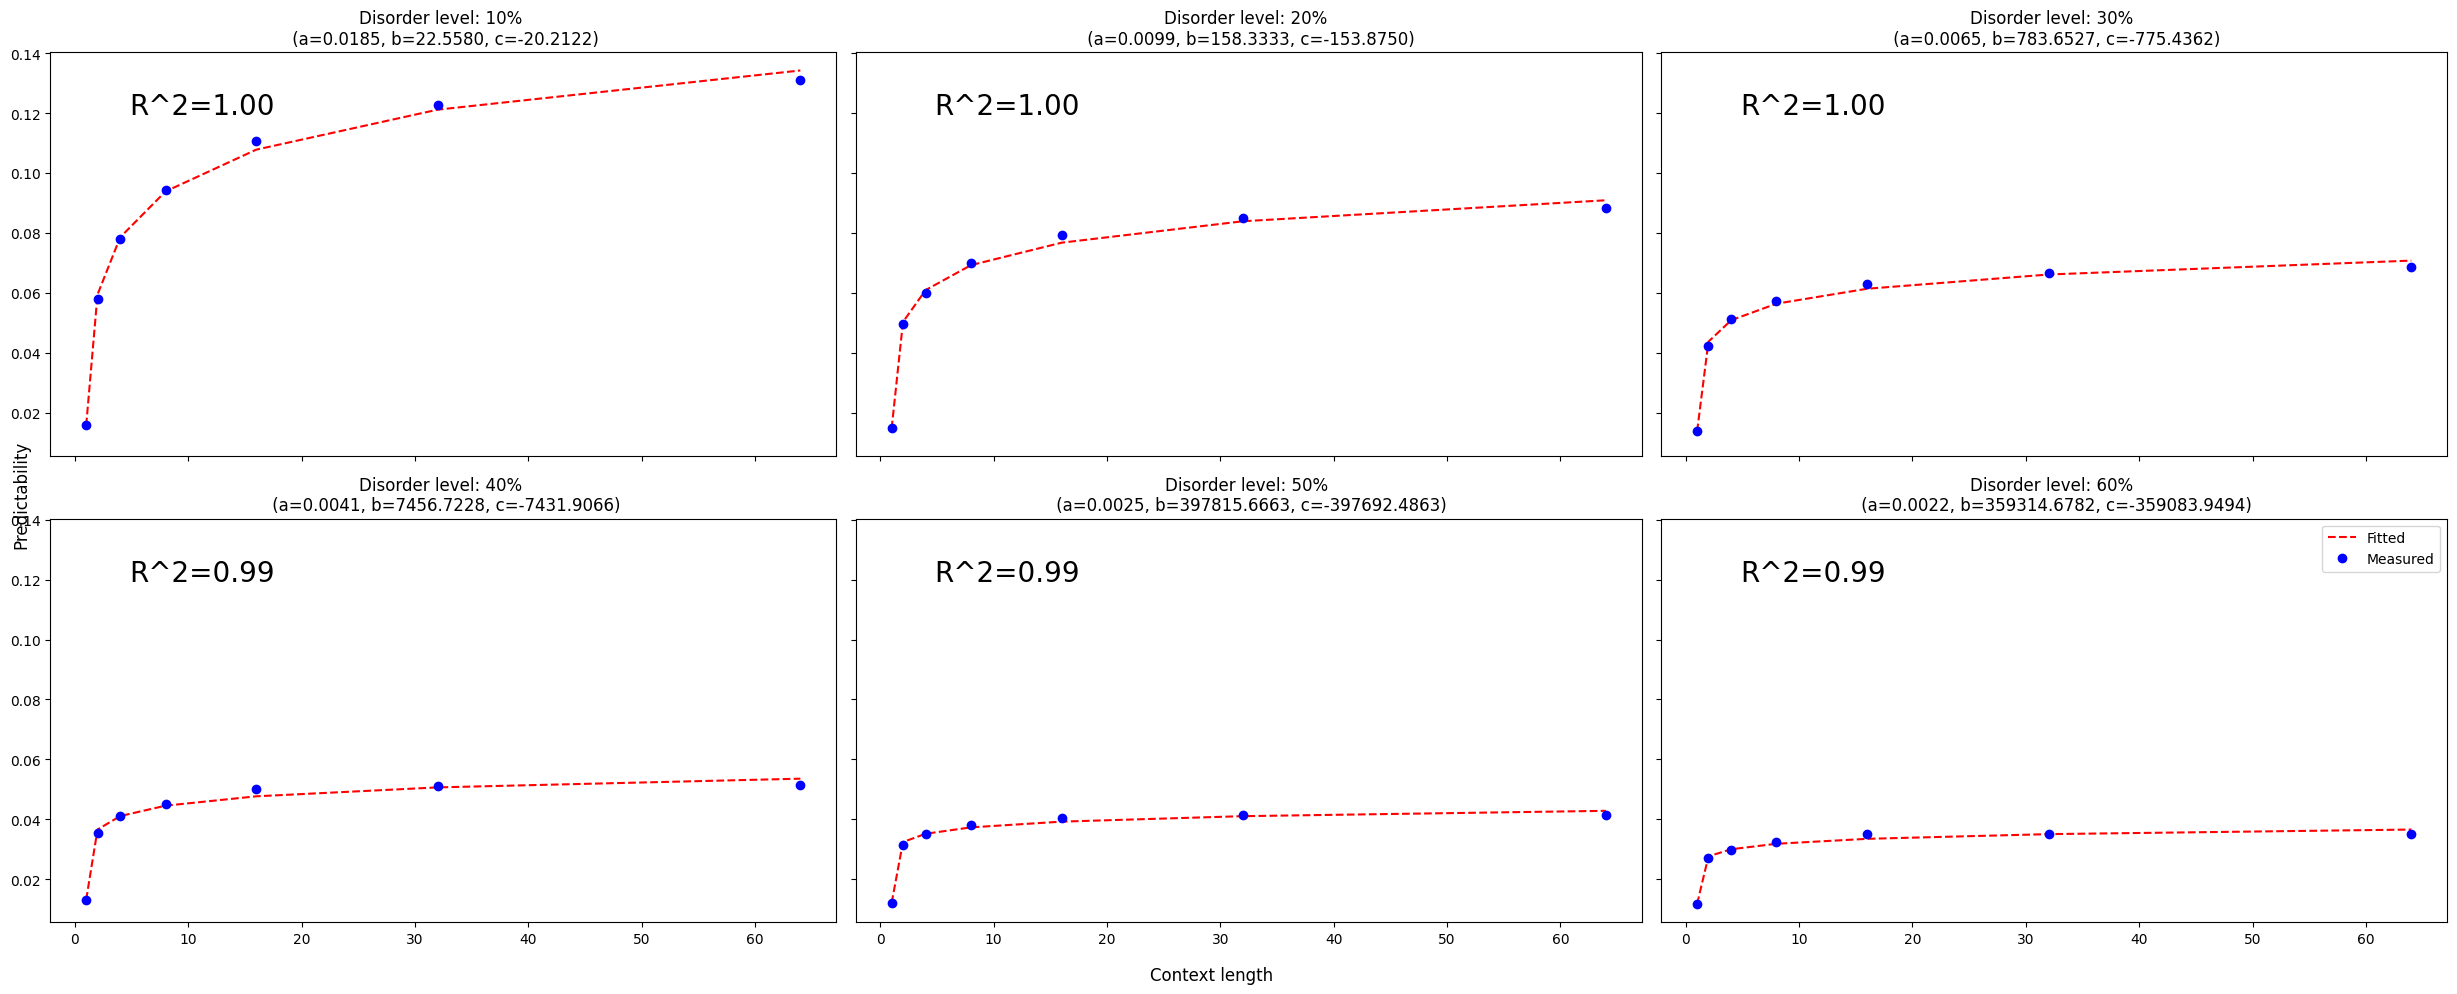

In [22]:
# log fit
def log_func(x, a, b, c):
    return a * np.log(b*x+c)


params_log=fit(df_agg, log_func)
plot_fit(df_agg, params_log, log_func)

c:\Users\吴法吴天\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


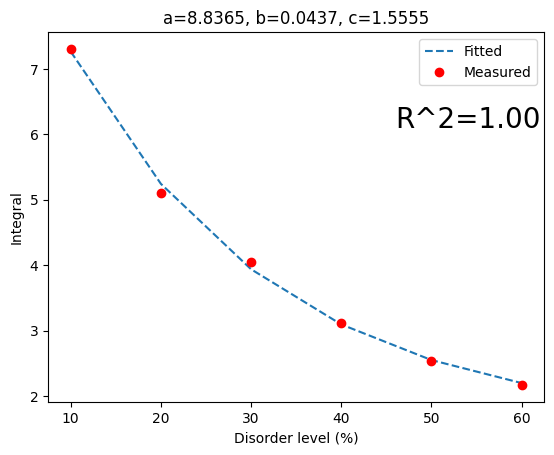

In [23]:
# log integral
def log_integral(x, a, b, c):
    integrand = lambda x: a * np.log(b * x + c)
    integral, error = quad(integrand, x[0], x[-1])
    return integral
    
x=df_agg.context_length.sort_values().unique()
for p in params_log:
    a, b, c=p['params']
    p['growth']=log_integral(x, a, b, c)
params_log=pd.DataFrame(params_log)


def exp_func(x, a, b, c):
    return a*np.exp(-b*x) +c

plot_growth(params_log, exp_func)

In [21]:
len(params_log['params'][0])

3

#### Exp_model

C:\Users\吴法吴天\AppData\Local\Temp\ipykernel_19868\1507054469.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs.ravel()[i].plot(df_level['context_length'], df_level['predictability'], 'ro', color='blue', label='Measured')


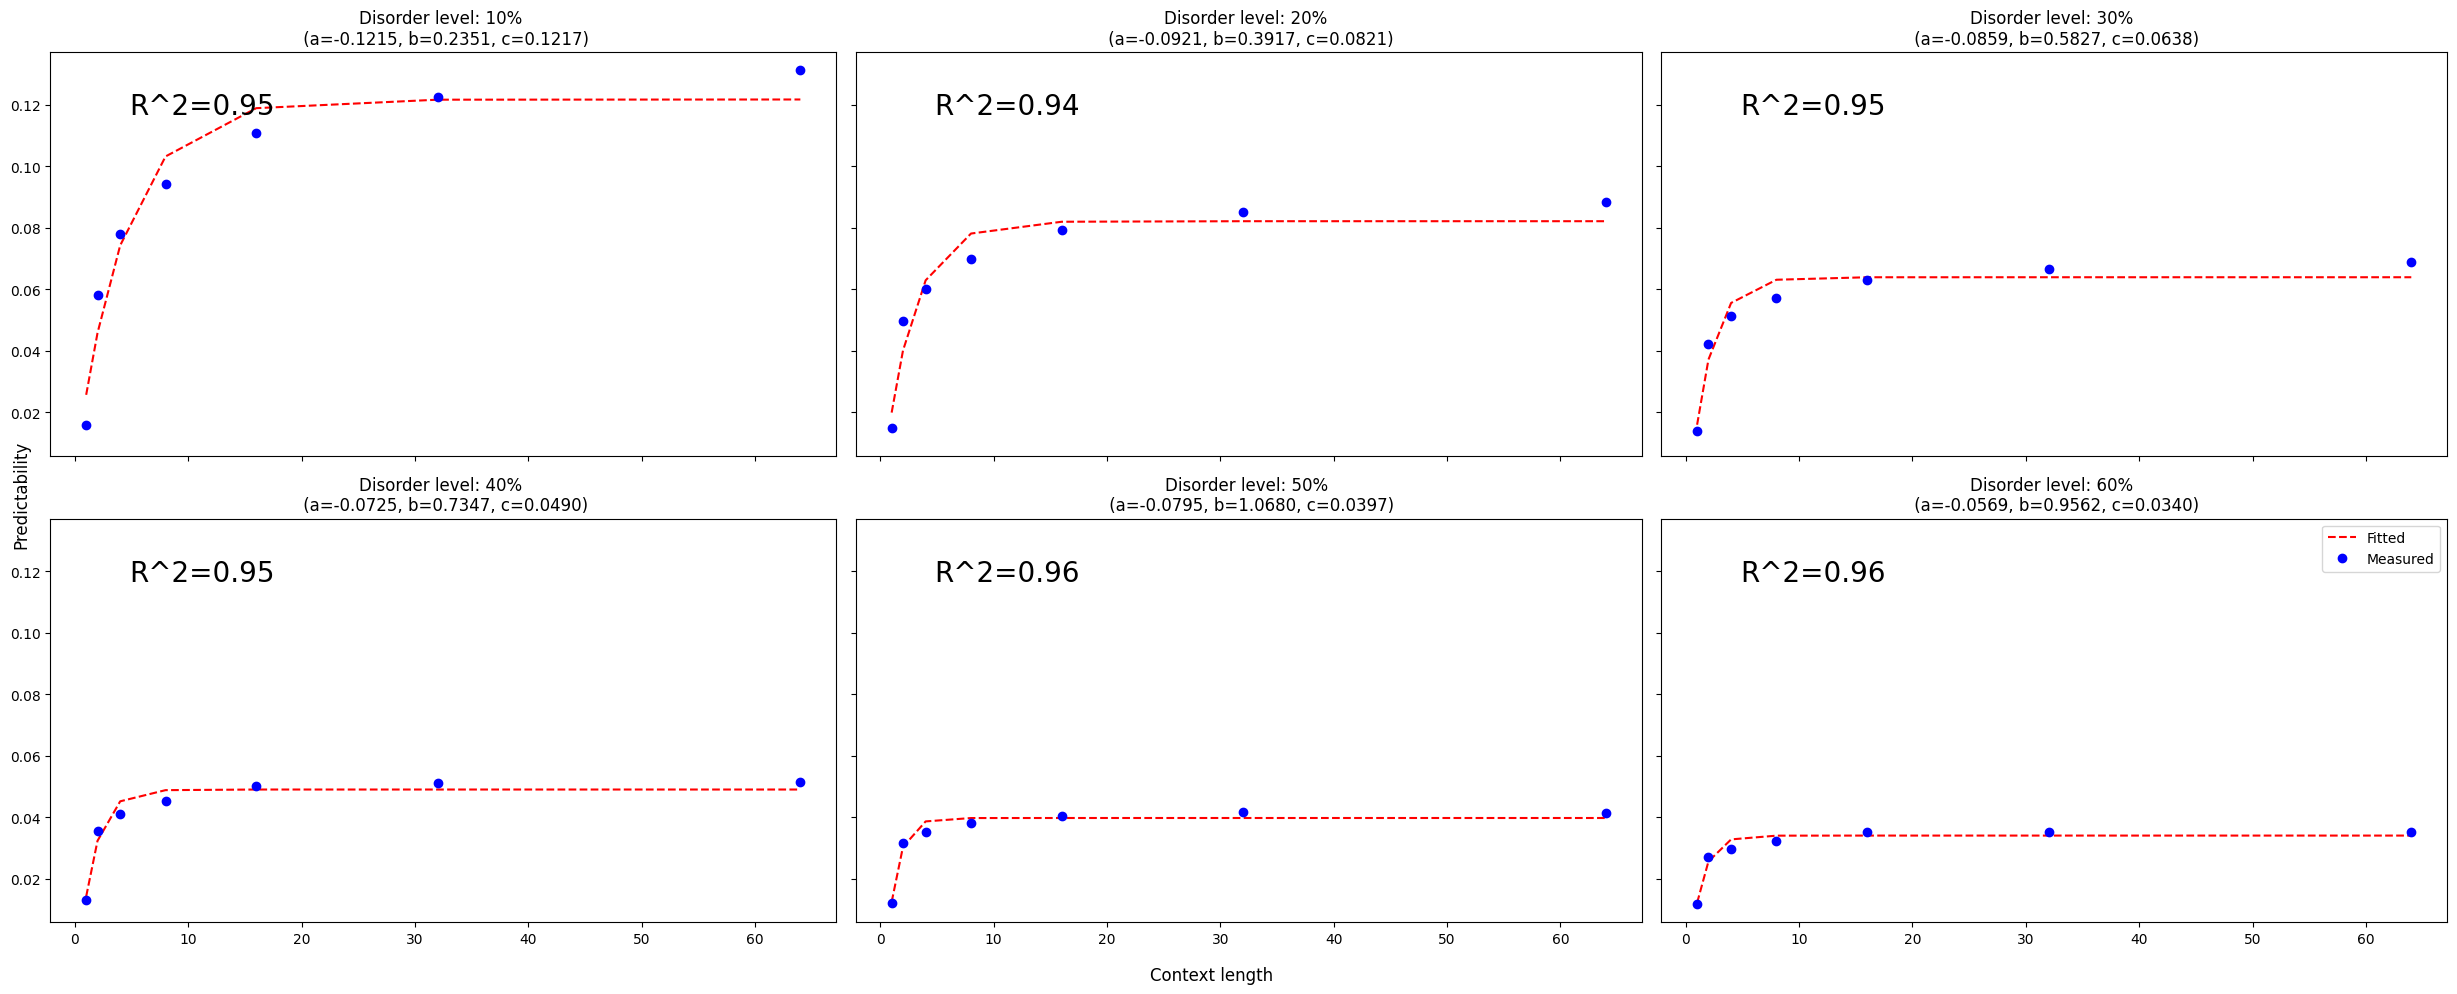

In [15]:
# exp_fit
def exp_func(x, a, b, c):
    return a*np.exp(-b*x) +c

params_exp=fit(df_agg, exp_func)
plot_fit(df_agg, params_exp, exp_func)

c:\Users\吴法吴天\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


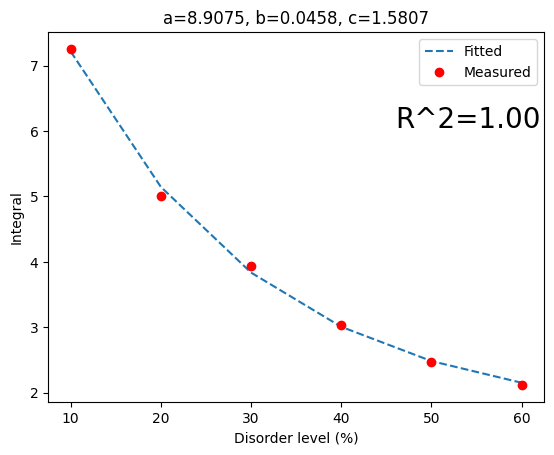

In [16]:
# exp integral
def exp_integral(x, a, b, c):
    integrand = lambda x: a * np.exp(-b * x) + c
    integral, error = quad(integrand, x[0], x[-1])
    return integral

x=df_agg.context_length.sort_values().unique()
for p in params_exp:
    a, b, c=p['params']
    p['growth']=exp_integral(x, a, b, c)
    
params_exp=pd.DataFrame(params_exp)
plot_growth(params_exp, exp_func)